In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib
import math

import copy # copy.deepcopy(dict_variable) to actually copy a dict without problems

import keijzer_exogan as ke

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# Load chunk
X[0] is a dict from regular chunk  
X[0][0] is a dict from .npy selection  

In [2]:
dir_ = 'F:\Jupyterlab\SRON-DCGAN\data\\'

X = ke.load_all_to_array(dir_,'chunck_0.pkgz')

  0%|                                                                                                                                                                  | 0/1 [00:00<?, ?it/s]c:\program files\python36\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.27s/it]


In [3]:
df = pd.read_csv('wavelengths_and_indices.csv', header=None, skiprows=[0], usecols=[1]) # load wavelengths
df.columns = ['x']
df = df.loc[df['x'] <= 16] # select only wavelengths <= 16

## Dict to ASPA function

In [4]:
def ASPA_v2(x, wavelengths):
    x = copy.deepcopy(x)
    wavelengths = wavelengths.copy()
    
    spectrum = x['data']['spectrum']
    spectrum = np.expand_dims(spectrum, axis=1) # change shape from (515,) to (515,1)
    params = x['param']

    for param in params:
        #print('Param: ', param)
        if 'mixratio' in param: 
            params[param] = np.log(np.abs(params[param])) # transform mixratio's because they are generated on logarithmic scale
    
    """
    Normalize params
    """
    # Min max values from training set, in the same order as params above: planet mass, temp, .... co mixratio.
    min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
    max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

    for i,param in enumerate(params):
        params[param] = scale_param(params[param], min_values[i], max_values[i])
        #print('%s: %s' % (param, params[param]))
    #print('-'*5)
    """
    Select bins
    """
    data = np.concatenate([wavelengths,spectrum], axis=1)
    data = pd.DataFrame(data)
    data.columns = ['x', 'y'] # x is wavelength, y is (R_p / R_s)^2
    
    # Could loop this, but right now this is more visual
    bin1 = data[data.x <= 0.8]
    bin2 = data[(data.x > 0.8) & (data.x <= 1.3)] # select data between 2 and 4 micron
    bin3 = data[(data.x > 1.3) & (data.x <= 2)]
    bin4 = data[(data.x > 2) & (data.x <= 4)]
    bin5 = data[(data.x > 4) & (data.x <= 6)]
    bin6 = data[(data.x > 6) & (data.x <= 10)]
    bin7 = data[(data.x > 10) & (data.x <= 14)]
    bin8 = data[data.x > 14]

    bins = [bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]
    
    """
    Normalize bins
    """
    scalers = [MinMaxScaler(feature_range=(0,1)).fit(b) for b in bins] # list of 8 scalers for the 8 bins
    mins = [ b.iloc[:,1].min() for b in bins] # .iloc[:,1] selects the R/R (y) only
    maxs = [ b.iloc[:,1].max() for b in bins]
    stds = [ b.iloc[:,1].std() for b in bins]
    #print(min(mins), max(maxs))
    bins_scaled = []
    for i,b in enumerate(bins):
        bins_scaled.append(scalers[i].transform(b))
        
    spectrum_scaled = np.concatenate(bins_scaled, axis=0)
    spectrum_scaled = spectrum_scaled[:,1]
    
    """
    Create the ASPA
    """
    
    """Spectrum"""
    aspa = np.zeros((32,32))

    row_length = 25 # amount of pixels used per row
    n_rows = math.ceil(len(spectrum_scaled) / row_length) # amount of rows the spectrum needs in the aspa, so for 415 data points, 415/32=12.96 -> 13 rows
    #print('Using %s rows' % n_rows)

    for i in range(n_rows): # for i in 

        start = i*row_length
        stop = start+row_length
        spec = spectrum_scaled[start:stop]

        if len(spec) != row_length:
            n_missing_points = row_length-len(spec)
            spec = np.append(spec, [0 for _ in range(n_missing_points)]) # for last row, if length != 32, fill remaining with 0's
            #print('Filled row with %s points' % n_missing_points)

        aspa[i, :row_length] = spec
        
    """ExoGAN params"""
    for i,param in enumerate(params):
        aspa[:16, 25+i:26+i] = params[param]
        
    """min max std values for spectrum bins"""
    for i in range(len(mins)):
        min_ = scale_param(mins[i], 0.005, 0.03)
        max_ = scale_param(maxs[i], 0.005, 0.03)
        std_ = scale_param(stds[i], 9e-6, 2e-4)

        aspa[16:17, i*4:i*4+4] = min_
        aspa[17:18, i*4:i*4+4] = std_
        aspa[18:19, i*4:i*4+4] = max_
        
    """Fill unused space with noice"""
    for i in range(13):
        noise = np.random.rand(32) # random noise betweem 0 and 1 for each row
        aspa[19+i:20+i*1, :] = noise
        
    return aspa

In [5]:
def scale_param(X, X_min, X_max):
    """
    Formule source: 
    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    
    In this case 1 is max, 0 is min
    """
    std = (X-X_min)/ (X_max - X_min)
    return std*(1 - 0)+0

In [6]:
wavelengths = pd.read_csv(dir_+'wnw_grid.txt', header=None).values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


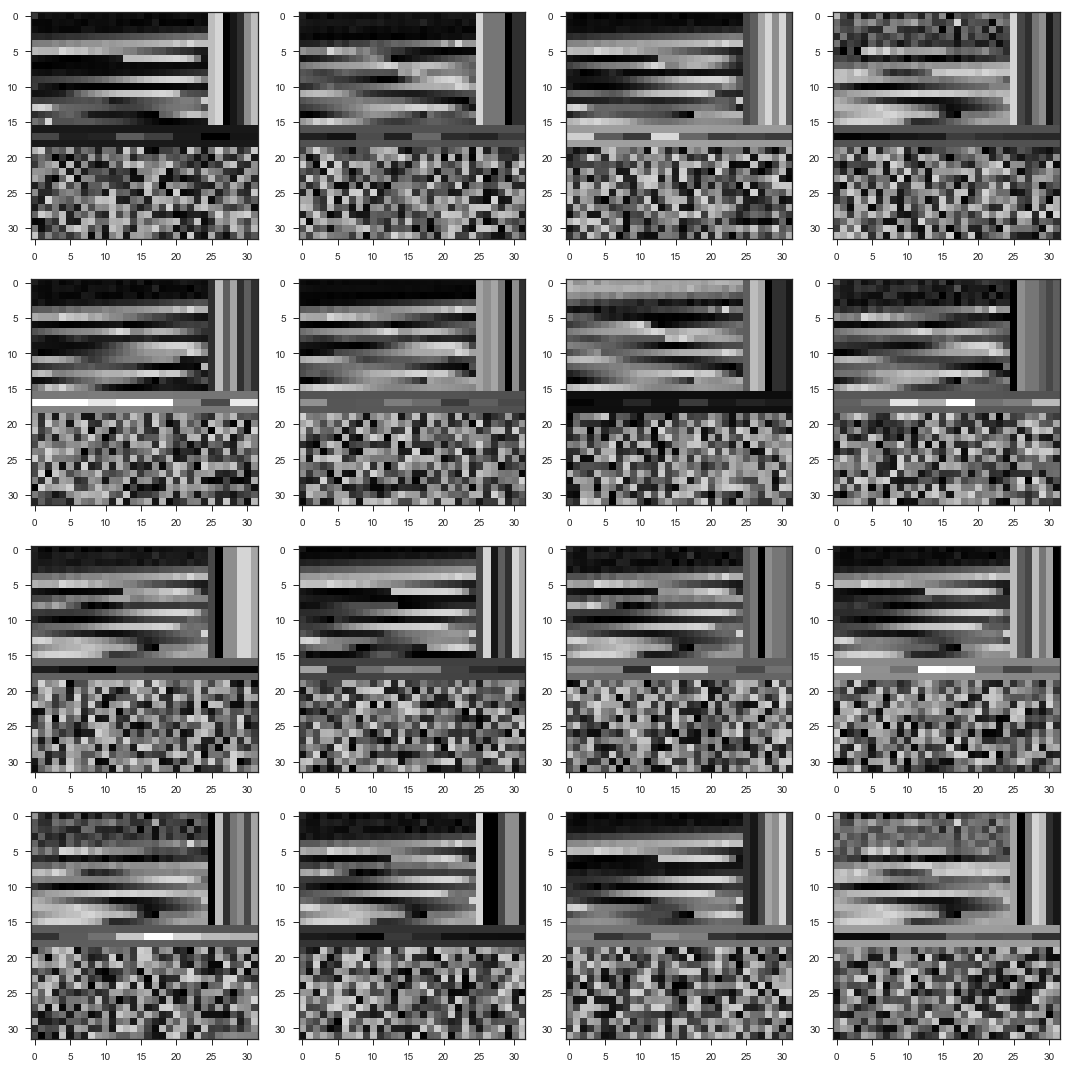

In [7]:
np.random.shuffle(X)

plt.figure(figsize=(15,15))
for i in tqdm(range(4*4)):
    image = ASPA_v2(X[i], wavelengths)
    
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='gray', vmin=0, vmax=1.2)
    plt.tight_layout()

## Inverse transform

In [51]:
i = 0
dict_ = X[i]

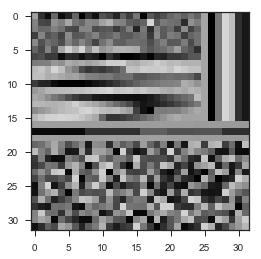

In [52]:
aspa = ASPA_v2(dict_, wavelengths)

plt.imshow(image, cmap='gray', vmin=0, vmax=1.2)

### Real values

In [53]:
params_original = copy.deepcopy(dict_['param'])
params_original

{'ch4_mixratio': 1e-08,
 'co2_mixratio': 0.0004641588833612782,
 'co_mixratio': 0.016681005372000592,
 'h2o_mixratio': 3.5938136638046254e-07,
 'planet_mass': 3.5429333333333333e+27,
 'planet_radius': 61366322.222222224,
 'temperature_profile': 2000.0}

In [76]:
np.log(1e-8)

-18.420680743952367

In [75]:
np.exp(-18.420680743952367)

9.999999999999982e-09

In [65]:
params_original = copy.deepcopy(dict_['param'])
for i,param in enumerate(params_original):
    if 'mixratio' in param: 
        params_original[param] = np.log((params_original[param]))**np.exp(1)

params_original

{'ch4_mixratio': -18.420680743952367,
 'co2_mixratio': -7.675283643313485,
 'co_mixratio': -4.093484609767192,
 'h2o_mixratio': -14.838881710406072,
 'planet_mass': 3.5429333333333333e+27,
 'planet_radius': 61366322.222222224,
 'temperature_profile': 2000.0}

No handles with labels found to put in legend.


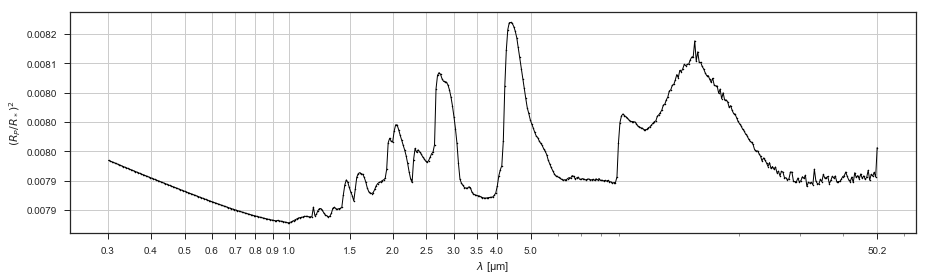

In [34]:
ke.plot_trans(wavelengths, dict_['data']['spectrum'])

# ---------------- Decoding ASPA ------------

In [35]:
def inverse_scale(X_, X_min, X_max):
    """
    X_ is scaled X
    X is unscaled X_
    """
    X = X_ * (X_max - X_min) + X_min
    return X

In [36]:
"""The values of the image parts from the aspa (still encoded)"""
# Grab the values 
spectrum = aspa[:16, :25].flatten()
params = [aspa[:16, 25+i:26+i].mean() for i in range(7)]
mins_ = [aspa[16:17, i*4:i*4+4].mean() for i in range(7)]
stds_ = [aspa[17:18, i*4:i*4+4].mean() for i in range(7)]
maxs_ = [aspa[18:19, i*4:i*4+4].mean() for i in range(7)]

In [37]:
"""Decode to arrays"""

# min max values for params used to decode
min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

# Initialize dict to be used for the param values
params_dict = {
    'planet_mass': 0,
    'temp_profile': 0,
    'ch4_mixratio': 0,
    'planet_radius': 0,
    'h2o_mixratio': 0,
    'co2_mixratio': 0,
    'co_mixratio': 0
}

In [77]:
for i,param in enumerate(params_dict):
    # put aspa values in dict
    params_dict[param] = params[i]
    
    # inverse scale these values
    params_dict[param] = inverse_scale(params[i], min_values[i], max_values[i])
    
    # scale mixratios from log back to linear
    if 'mixratio' in param: 
        params_dict[param] = np.exp(params_dict[param])
        print(param, params_dict[param])

params_dict

ch4_mixratio 9.999999999999982e-09
h2o_mixratio 3.5938136638046265e-07
co2_mixratio 0.0004641588833612784
co_mixratio 0.0166810053720006


{'ch4_mixratio': 9.999999999999982e-09,
 'co2_mixratio': 0.0004641588833612784,
 'co_mixratio': 0.0166810053720006,
 'h2o_mixratio': 3.5938136638046265e-07,
 'planet_mass': 3.5429333333333333e+27,
 'planet_radius': 61366322.222222224,
 'temp_profile': 2000.0}

In [24]:
[inverse_scale(params[param], min_values[i], max_values[i]) for i,param in range(7)]

TypeError: 'int' object is not iterable

In [ ]:
params = [10**inverse_scale(aspa[:16, 25+i:26+i].mean(), min_values[i], max_values[i]) for i in range(7)]

print(params)
mins_ = [inverse_scale(mins_[i].mean(), 0.005, 0.03) for i in range(7)]
stds_ = [inverse_scale(stds_[i].mean(), 0.005, 0.03) for i in range(7)]
maxs_ = [inverse_scale(maxs_[i].mean(), 1e-7, 1e-4) for i in range(7)]

In [ ]:
param_values

In [ ]:
params